In [1]:
from datetime import datetime
import pandas as pd

import numpy as np
# Technical indicators
from ta.momentum import stochrsi,rsi, awesome_oscillator, williams_r
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import volume_weighted_average_price, ease_of_movement

import warnings
warnings.filterwarnings('ignore')

from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
import matplotlib.pyplot as plt


# Utils functions

In [2]:
def addIndicators(df:pd.DataFrame) -> pd.DataFrame:
    """Apply indicators to the DataFrame.

    Args:
        df (pd.DataFrame): The dataframe you want to add indicators on.
        b_engulfings (bool, optional): Add bearish and bullish engulfing indicators. Defaults to False.
        derivative (bool, optional): Add the first derivative of the Close price. Defaults to False.
        double_derivative (bool, optional): Add the second derivative of the Close price. Defaults to False.
        heikin_ashi (bool, optional): Add the heikin_ashi candle to the dataframe. Defaults to False.
        chandelier_exit (bool, optional): Add the CE signal short and long to the dataframe. Defaults to False.

    Returns:
        pd.DataFrame: The same dataframe with indicators
    """
    df['EMA100'] = ema_indicator(df.Close,100)
    df['EMA200'] = ema_indicator(df.Close,200)
    df['Stoch_RSI'] = stochrsi(df.Close, 14, smooth1=3, smooth2=3)
    df['AO']= awesome_oscillator(df['High'],df['Low'],window1=6,window2=22)
    df['WillR'] = williams_r(high=df['High'], low=df['Low'], close=df['Close'], lbp=14)
    return df.dropna()


In [3]:
def checkBuyCondition(row:pd.Series,previous_row:pd.Series=None)->bool:
    """Check if buying conditions are reached for a row.

    Args:
        row (pd.Series): The current row.
        previous_row (pd.Series, optional): The previous row. Defaults to None.

    Returns:
        bool: if there is a buy signal or not.
    """
    return True if row['AO'] >= 0 and previous_row['AO'] > row['AO'] and row['WillR'] < -85 and row['EMA100'] > row['EMA200'] else False
    #return True if row['Bollinger_high']<=row['Close'] else False


In [4]:

def checkSellCondition(row:pd.Series,previous_row:pd.Series=None)->bool:
    """Check if selling conditions are reached for a row.

    Args:
        row (pd.Series): The current row.
        previous_row (pd.Series, optional): The previous row. Defaults to None.

    Returns:
        bool: if there is a sell signal or not.
    """
    return True if  (row['AO'] < 0 and row['Stoch_RSI'] > 0.2) or row['WillR'] > -10 else False
    #return True if row['Bollinger_low']>=row['Close'] else False

# Variables

In [5]:
# -- Hyper parameters --
stochOverBought = 0.8
stochOverSold = 0.2
willOverSold = -85
willOverBought = -10


# Données

In [10]:
SYMBOL= 'ETH'
df = addIndicators(loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv'))
#df = df[-10000:]
df.head()

Total records : 21704 rows


,Open,High,Low,Close,Volume,Timestamp,EMA100,EMA200,Stoch_RSI,AO,WillR
Date,,,,,,,,,,,
2020-01-09 08:00:00,139.41,140.25,139.34,139.88,1012.866101,1578553200,139.947919,137.221940,0.790398,-0.632273,-37.868481
2020-01-09 09:00:00,139.88,140.04,139.11,139.38,601.317742,1578556800,139.936673,137.243413,0.645966,-0.638939,-49.206349
2020-01-09 10:00:00,139.38,139.38,138.06,138.37,1143.721091,1578560400,139.905649,137.254623,0.000000,-0.614167,-72.108844
2020-01-09 11:00:00,138.37,139.16,137.73,138.79,1334.842736,1578564000,139.883557,137.269900,0.264699,-0.671212,-72.251309
2020-01-09 12:00:00,138.79,138.79,137.81,138.17,546.081180,1578567600,139.849625,137.278856,0.000000,-0.672955,-88.481675


Period : [2020-01-09 08:00:00] -> [2022-08-24 21:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 1240.32 $
Performance vs US Dollar : 24.03 %
Buy and Hold Performence : 1107.46 %
Performance vs Buy and Hold : -97.83 %
Best trade : +7.81 %, the 2021-01-12 17:00:00
Worst trade : -8.11 %, the 2022-08-19 17:00:00
Worst drawBack : -13.0 %
Total fees :  238.15 $

----- Trades Informations -----
Total trades on period : 139
Number of positive trades : 93
Number of negative trades :  46
Trades win rate ratio : 66.91 %
Average trades performance : 0.25 %
Average positive trades : 1.23 %
Average negative trades : -1.73 %

----- Plot -----


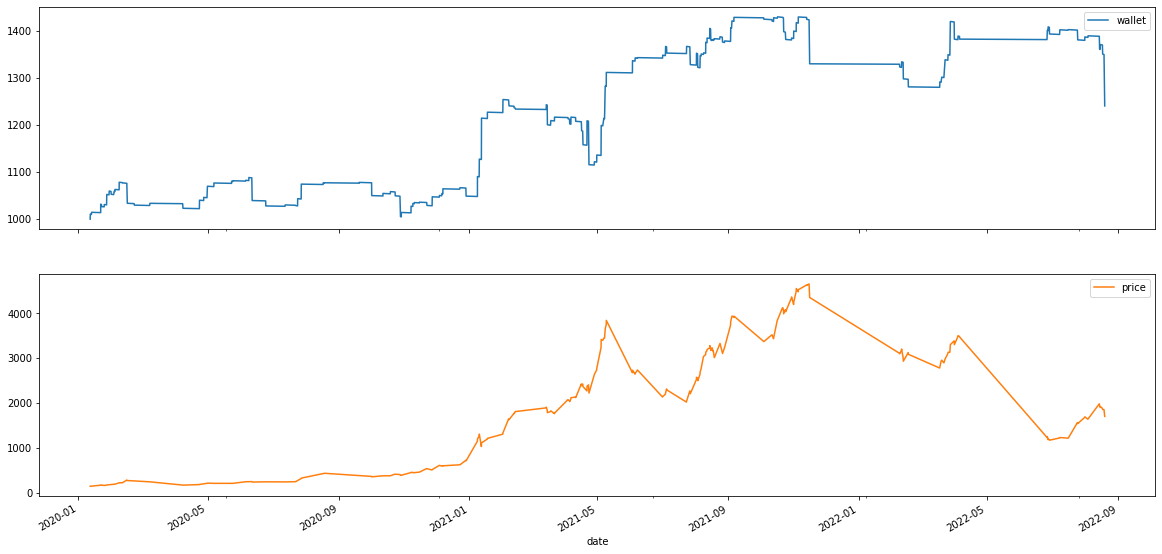

In [11]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row['AO'] >= 0 and previous_row['AO'] > row['AO'] and row['WillR'] < -85 and row['EMA100'] > row['EMA200'] else False


def sellCondition(row:pd.Series,previous_row:pd.Series=None)->bool:
    """Check if selling conditions are reached for a row.

    Args:
        row (pd.Series): The current row.
        previous_row (pd.Series, optional): The previous row. Defaults to None.

    Returns:
        bool: if there is a sell signal or not.
    """
    return True if  (row['AO'] < 0 and row['Stoch_RSI'] > 0.2) or row['WillR'] > -10 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

In [9]:
df['BUY_SELL'] = 'HOLD'
tp=0.15
sl = 0.05
POSITION_OPENED = False
for i in range(1,len(df)):
    if POSITION_OPENED==False:
        if checkBuyCondition(df.iloc[i],df.iloc[i-1])==True:
            POSITION_OPENED=True
            LASY_BUY_PRICE = df.iloc[i].Close
            df['BUY_SELL'].iloc[i] = 'BUY'
    else:
        if checkSellCondition(df.iloc[i],df.iloc[i-1])==True:
            POSITION_OPENED=False
            df['BUY_SELL'].iloc[i] = 'SELL'
        #elif df.High.iloc[i]>=LASY_BUY_PRICE+LASY_BUY_PRICE*tp:
        #    POSITION_OPENED==False
        #    df['BUY_SELL'].iloc[i] = 'SELL'
        elif df.Low.iloc[i]<=LASY_BUY_PRICE-LASY_BUY_PRICE*sl:
            POSITION_OPENED==False
            df['BUY_SELL'].iloc[i] = 'SELL'
            
            
trades = df[df['BUY_SELL']!='HOLD'][['Close','BUY_SELL']]
trades['Change'] = trades['Close'].pct_change()*100
trades_sells = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades_sells.Change.sum())} %")
print(f"Winrate : {round(100*len(trades_sells[trades_sells['Change']>0].Change)/len(trades_sells))} %")
print(f"Total trades : {len(trades)}")
print(f"Average pct {trades_sells.Change.mean()}%")
print(f"Average gain {trades_sells[trades_sells['Change']>0].Change.mean()}%")
print(f"Average loss {trades_sells[trades_sells['Change']<0].Change.mean()}%")
#print(f"Total not worthy trade {trades_sells[trades_sells['Change']<0.1]['Change'].count()}")
            

Gain : -4 %
Winrate : 59 %
Total trades : 244
Average pct -0.027614777123501313%
Average gain 1.6257308998893516%
Average loss -2.3895371728561483%


In [ ]:
equity = 1000
for i in range(len(trades_sells)):
    equity = equity*(1+trades_sells.iloc[i].Change/100)
        
print(equity)

4575.035034177553


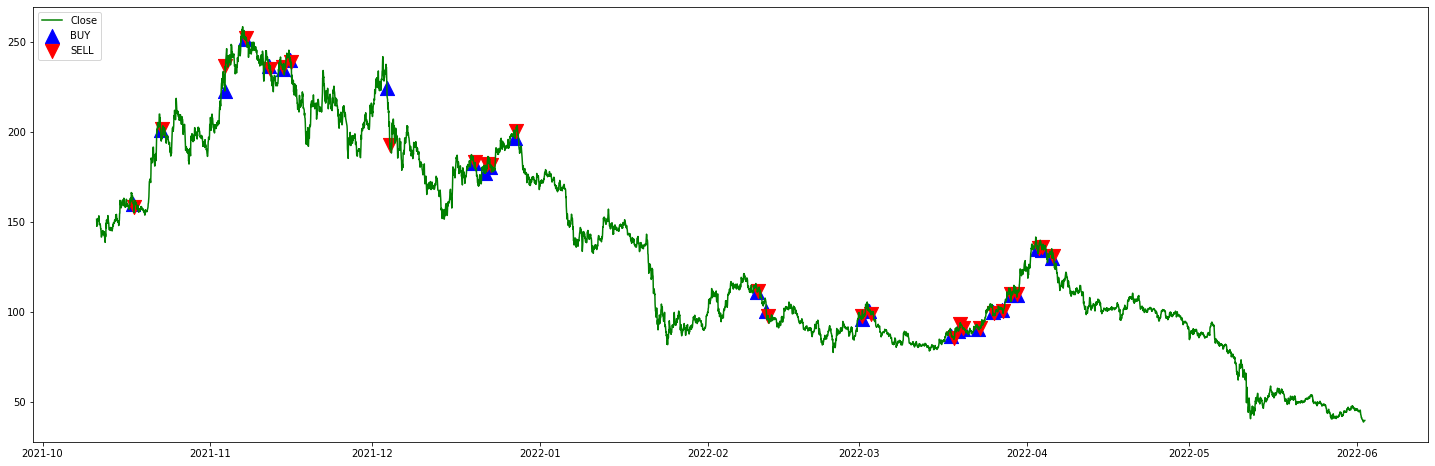

In [ ]:
fig, ax = plt.subplots(1, figsize=(25,8))

ax.plot(df.Close, color='green',label='Close')
ax.scatter(df[df['BUY_SELL']=='BUY'].index, df[df['BUY_SELL']=='BUY'].Close, color='blue',label='BUY',marker='^',s=200)
ax.scatter(df[df['BUY_SELL']=='SELL'].index, df[df['BUY_SELL']=='SELL'].Close, color='red',label='SELL',marker='v',s=200)
ax.legend(loc="upper left")